# Constants

In [1]:
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # this is required
os.environ['CUDA_VISIBLE_DEVICES'] = '1'         # set to '0' for GPU0, '1' for GPU1 or '2' for GPU2. Check "gpustat" in a terminal.

In [2]:
glob_path = '/opt/iui-datarelease3-sose2021/*.csv'

pickle_file = '../data.pickle'

cenario = 'SYY'

win_sz = 50
stride_sz = 25 

In [3]:
from matplotlib import pyplot as plt

def pplot(dd):
    x = dd.shape[0]
    fix = int(x/3)+1
    fiy = 3
    fig, axs = plt.subplots(fix, fiy, figsize=(3*fiy, 9*fix))
    
    for i in range(x):
        axs[int(i/3)][i%3].plot(dd[i])

# Loading Data

In [4]:
from glob import glob
import pandas as pd
from tqdm import tqdm

def dl_from_blob(filename, user_filter=None):
    
    dic_data = []
    
    for p in tqdm(glob(glob_path)):
        path = p
        filename = path.split('/')[-1].split('.')[0]
        splitname = filename.split('_')
        user = int(splitname[0][1:])
        if (user_filter):
            if (user != user_filter):
                continue
        scenario = splitname[1][len('Scenario'):]
        heightnorm = splitname[2][len('HeightNormalization'):] == 'True'
        armnorm = splitname[3][len('ArmNormalization'):] == 'True'
        rep =  int(splitname[4][len('Repetition'):])
        session =  int(splitname[5][len('Session'):])
        data = pd.read_csv(path)
        dic_data.append(
            {
                'filename': path,
                'user': user,
                'scenario': scenario,
                'heightnorm': heightnorm,
                'armnorm': armnorm,
                'rep': rep,
                'session': session,
                'data': data 
            }
        )
    return dic_data

In [5]:
import pickle

def save_pickle(f, structure):
    _p = open(f, 'wb')
    pickle.dump(structure, _p)
    _p.close()

In [6]:
def load_pickles(f) -> list:
    _p = open(pickle_file, 'rb')
    _d = pickle.load(_p)
    _p.close()
    
    return _d

In [7]:
%%time

def load_data() -> list:
    if os.path.isfile(pickle_file):
        print(f'{pickle_file} found...')
        return load_pickles(pickle_file)
    print(f'Didn\'t find {pickle_file}...')
    all_data = dl_from_blob(glob_path)
    print(f'Creating {pickle_file}...')
    save_pickle(pickle_file, all_data)
    return all_data

print("Loading data...")
dic_data = load_data()
print(len(dic_data))

Loading data...
../data.pickle found...
768
CPU times: user 615 ms, sys: 2.24 s, total: 2.85 s
Wall time: 2.85 s


In [8]:
# Categorized Data
cdata = dict() 
# Sorting, HeightNorm, ArmNorm
cdata['SYY'] = list() 
cdata['SYN'] = list() 
cdata['SNY'] = list() 
cdata['SNN'] = list() 

# Jenga, HeightNorm, ArmNorm
cdata['JYY'] = list() 
cdata['JYN'] = list() 
cdata['JNY'] = list() 
cdata['JNN'] = list() 
for d in dic_data:
    if d['scenario'] == 'Sorting':
        if d['heightnorm']:
            if d['armnorm']:
                cdata['SYY'].append(d)
            else:
                cdata['SYN'].append(d)
        else:
            if d['armnorm']:
                cdata['SNY'].append(d)
            else:
                cdata['SNN'].append(d)
    elif d['scenario'] == 'Jenga':
        if d['heightnorm']:
            if d['armnorm']:
                cdata['JYY'].append(d)
            else:
                cdata['JYN'].append(d)
        else:
            if d['armnorm']:
                cdata['JNY'].append(d)
            else:
                cdata['JNN'].append(d)

# for k,v in cdata.items():
#     print(k,': ',len(v))
# test_entry = pickle.loads(pickle.dumps(cdata['SYY'][17]))
# test_entry['data']

# Preprocessing

In [9]:
def drop(entry) -> pd.DataFrame:
    droptable = ['participantID', 'FrameID', 'Scenario', 'HeightNormalization', 'ArmNormalization', 'Repetition', 'Session', 'Unnamed: 0']
    centry = pickle.loads(pickle.dumps(entry))
    return centry['data'].drop(droptable, axis=1)

In [10]:
def floatize(entry) -> pd.DataFrame:
    centry = pickle.loads(pickle.dumps(entry))
    centry['data']['LeftHandTrackingAccuracy'] = (entry['data']['LeftHandTrackingAccuracy'] == 'High') * 1.0
    centry['data']['RightHandTrackingAccuracy'] = (entry['data']['RightHandTrackingAccuracy'] == 'High') * 1.0
    return centry['data']

In [11]:
import numpy as np
right_Hand_ident='right_Hand'
left_Hand_ident='left_hand'

def rem_low_acc(entry) -> pd.DataFrame:
    centry = pickle.loads(pickle.dumps(entry))
    right_Hand_cols = [c for c in centry['data'] if right_Hand_ident in c]
    left_Hand_cols = [c for c in centry['data'] if left_Hand_ident in c]
    
    centry['data'].loc[centry['data']['RightHandTrackingAccuracy'] == 0.0, right_Hand_cols] = np.nan
    centry['data'].loc[centry['data']['LeftHandTrackingAccuracy'] == 0.0, left_Hand_cols] = np.nan
    return centry['data']

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

stride = 150
def pad(entry) -> pd.DataFrame:
    centry = pickle.loads(pickle.dumps(entry))
    cols = centry['data'].columns
    pentry = pad_sequences(centry['data'].T.to_numpy(),
                                        maxlen=(int(centry['data'].shape[0]/stride)+1)*stride,
                                        dtype='float64',
                                        padding='pre', 
                                        truncating='post',
                                        value=np.nan
                                       ) 
    pdentry = pd.DataFrame(pentry.T, columns=cols)
    pdentry.loc[0] = [0 for _ in cols]
    return pdentry

In [13]:
def interpol(entry) -> pd.DataFrame:
    centry = pickle.loads(pickle.dumps(entry))
    return centry['data'].interpolate(method='linear', axis=0)

In [14]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

def slicing(entry):
    centry = pickle.loads(pickle.dumps(entry))
    return timeseries_dataset_from_array(
        data=centry['data'], 
        targets=[centry['user'] for _ in range(centry['data'].shape[0])], 
        sequence_length=win_sz,
        sequence_stride=stride_sz, 
        batch_size=8, 
        seed=177013
    )

In [15]:
classes = 16 # dynamic

def preproc(data):
    res_list = list()
    
    for e in tqdm(data):
        res_list.append(preproc_entry(e))
        
    return res_list
        
def preproc_entry(entry):
    entry2 = pickle.loads(pickle.dumps(entry))
    entry2['data'] = drop(entry2)
    
    entry3 = pickle.loads(pickle.dumps(entry2))
    entry3['data'] = floatize(entry3)
    
    entry4 = pickle.loads(pickle.dumps(entry3))
    entry4['data'] = rem_low_acc(entry4)
    
    entry5 = pickle.loads(pickle.dumps(entry4))
    entry5['data'] = pad(entry5)
    
    entry6 = pickle.loads(pickle.dumps(entry5))
    entry6['data'] = interpol(entry6)
    
    entry7 = pickle.loads(pickle.dumps(entry6))
    entry7['data'] = slicing(entry7)
    
    return entry7

pdata = preproc(cdata[cenario])

100%|██████████| 96/96 [00:15<00:00,  6.14it/s]


# Building Model

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D

def build_model(train):
    s = train[0].shape

    model = Sequential()
    ncount = s[0]*s[1]
    
    model.add(Flatten(input_shape=s))
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.1))
    
    for i in range(1,6):
        model.add(Dense(int(ncount/pow(3,i)), activation='relu'))
        model.add(Dropout(0.1))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss="categorical_crossentropy", 
        metrics=["acc"],
    )

    return model

In [17]:
checkpoint_file = './goat.weights'

def train_model(X_train, y_train):
    model = build_model(X_train)
    
    model.summary()

    history = model.fit(X_train, 
              y_train,
              epochs=30,
              batch_size=128,
              shuffle=True,
              verbose=0,
             )
    return model, history

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

train = np.array([x['data'] for x in pdata if x['session'] == 1])
test = np.array([x['data'] for x in pdata if x['session'] == 2])

len(train), len(test)

(48, 48)

In [19]:
%%time
X_train = list()
y_train = list()

train = list()
test = list()

for x in pdata:
    if x['session'] == 1:
        train.append(
            {
                'label': x['user'],
                'data': list()
            })
        for y in x['data'].unbatch().as_numpy_iterator():
            X_train.append(y[0])
            y_train.append(y[1])
            
            train[-1]['data'].append(y[0])
    if x['session'] == 2:
        test.append(
            {
                'label': x['user'],
                'data': list()
            })
        for y in x['data'].unbatch().as_numpy_iterator():
            test[-1]['data'].append(y[0])

X_train = np.array(X_train)
y_train = np.array(y_train)

CPU times: user 8.86 s, sys: 3.63 s, total: 12.5 s
Wall time: 4.7 s


In [20]:
lb = LabelBinarizer()
yy_train = lb.fit_transform(y_train)

for e in test:
    e['label'] = lb.transform([e['label']])
    e['data'] = np.array(e['data'])
    
for e in train:
    e['label'] = lb.transform([e['label']])
    e['data'] = np.array(e['data'])

print(X_train.shape)
print(yy_train.shape)


(5832, 50, 338)
(5832, 16)


In [21]:
for e in test:
    print(f"{lb.inverse_transform(e['label'])[0]:2d}: {len(e['data']):3d} {e['data'].shape}")

 4:  53 (53, 50, 338)
14:  35 (35, 50, 338)
12:  65 (65, 50, 338)
 8: 149 (149, 50, 338)
 1:  53 (53, 50, 338)
 3: 107 (107, 50, 338)
11:  53 (53, 50, 338)
 3: 125 (125, 50, 338)
 1:  41 (41, 50, 338)
13:  71 (71, 50, 338)
15:  59 (59, 50, 338)
 3:  77 (77, 50, 338)
10: 119 (119, 50, 338)
 6:  47 (47, 50, 338)
14:  41 (41, 50, 338)
 5: 167 (167, 50, 338)
 8:  89 (89, 50, 338)
14:  41 (41, 50, 338)
 9:  71 (71, 50, 338)
10:  77 (77, 50, 338)
 8:  77 (77, 50, 338)
16:  77 (77, 50, 338)
16:  77 (77, 50, 338)
 2:  59 (59, 50, 338)
 9:  77 (77, 50, 338)
15:  77 (77, 50, 338)
 5: 101 (101, 50, 338)
16:  71 (71, 50, 338)
15:  71 (71, 50, 338)
12:  95 (95, 50, 338)
 6:  71 (71, 50, 338)
 2:  53 (53, 50, 338)
12: 845 (845, 50, 338)
 7:  65 (65, 50, 338)
 2:  65 (65, 50, 338)
13:  95 (95, 50, 338)
 5: 125 (125, 50, 338)
11:  65 (65, 50, 338)
 7:  59 (59, 50, 338)
10:  77 (77, 50, 338)
 6:  59 (59, 50, 338)
 7:  53 (53, 50, 338)
 1: 101 (101, 50, 338)
13:  71 (71, 50, 338)
11:  59 (59, 50, 338)
 

In [22]:
%%time
model, history = train_model(np.array(X_train), np.array(yy_train))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16900)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16900)             67600     
_________________________________________________________________
dropout (Dropout)            (None, 16900)             0         
_________________________________________________________________
dense (Dense)                (None, 5633)              95203333  
_________________________________________________________________
dropout_1 (Dropout)          (None, 5633)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1877)              10575018  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1877)              0

In [23]:
def predict(model, entry):
    p_dict = dict()
    predictions = model.predict_classes(entry['data'])
    
    for p in predictions:
        if p in p_dict:
            p_dict[p] += 1
        else:
            p_dict[p] = 1
    prediction = max(p_dict, key=p_dict.get)
    return prediction


In [24]:
ltest = [lb.inverse_transform(e['label'])[0] for e in test]
ptest = [predict(model, e) for e in test]

# for e in test:
#     print(f"Label:      {lb.inverse_transform(e['label'])[0]:2d}")
#     print(f"Prediction: {predict(model, e):2d}\n_______________")

/opt/jupyterhub/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [25]:
ltrain = [lb.inverse_transform(e['label'])[0] for e in train]
ptrain = [predict(model, e) for e in train]
# for e in train:
#     print(f"Label:      {lb.inverse_transform(e['label'])[0]:2d}")
#     print(f"Prediction: {predict(model, e):2d}\n_______________")

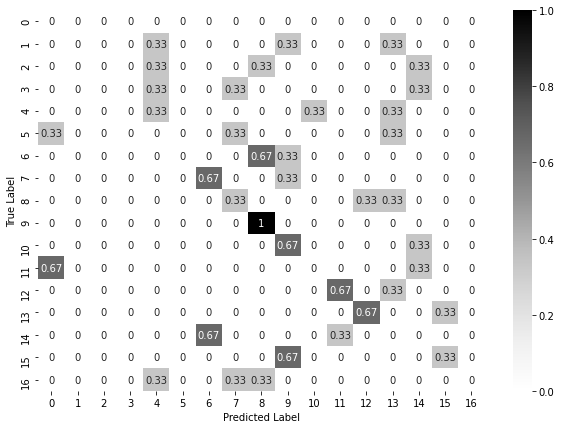

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

set_digits = { 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

train_cm = confusion_matrix(ltrain, ptrain, normalize='true')
test_cm = confusion_matrix(ltest, ptest, normalize='true')

df_cm = pd.DataFrame(test_cm, index=set_digits, columns=set_digits)
plt.figure(figsize = (10,7))
sn_plot = sn.heatmap(df_cm, annot=True, cmap="Greys")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()